# Параметры корреляции для двумерного нормального распределения

Необходимо сгенерировать выборки размерами 20, 60, 100 для нормального двумерного распределения. Коэффициент корреляции взять равным 0, 0.5, 0.9. Каждую выборку генерировать 1000 раз и для неё вычислять: среднее значение, среднее значение квадрата и дисперсию коэффициентов корреляции Пирсона, Спирмена и квадратного коэффициента корреляции. Повторить все вычисления для смеси нормальных распределений. Изобразить сгенерированные точки на плоскости и нарисовать эллипс равновероятности.

Подключаем все необходимые библиотеки

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import statistics
from tabulate import tabulate
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

Объявление массивов и переменных:

In [2]:
sizes = [20, 60, 100]
ros = [0, 0.5, 0.9]
REPETITIONS = 1000

Функция, генерирующая нормальное двумерное распределение:

In [3]:
def multivariate_normal(size, ro):
    return stats.multivariate_normal.rvs([0, 0], [[1.0, ro], [ro, 1.0]], size=size)

Функция, генерирующая смесь нормальных распределений:

In [4]:
def mix_multivariate_normal(size, ro):
    return 0.9 * stats.multivariate_normal.rvs([0, 0], [[1, 0.9], [0.9, 1]], size) + 0.1 * stats.multivariate_normal.rvs([0, 0], [[10, -0.9], [-0.9, 10]], size)

Функция, вычисляющая квадрантный коэффициент корреляции:

In [5]:
def quadrant_coefficient(x, y):
    size = len(x)
    med_x = np.median(x)
    med_y = np.median(y)
    n = {1: 0, 2: 0, 3: 0, 4: 0}
    for i in range(size):
        if x[i] >= med_x and y[i] >= med_y:
            n[1] += 1
        elif x[i] < med_x and y[i] >= med_y:
            n[2] += 1
        elif x[i] < med_x and y[i] < med_y:
            n[3] += 1
        elif x[i] >= med_x and y[i] < med_y:
            n[4] += 1
    return (n[1] + n[3] - n[2] - n[4]) / size

Функция, вычисляющая различные коэффициенты корреляции:

In [6]:
def count_coefficients(get_sample, size, ro):
    pearson, quadrant, spirman = [], [], []
    for i in range(REPETITIONS):
        sample = get_sample(size, ro)
        x, y = sample[:, 0], sample[:, 1]
        pearson.append(stats.pearsonr(x, y)[0])
        spirman.append(stats.spearmanr(x, y)[0])
        quadrant.append(quadrant_coefficient(x, y))
    return pearson, spirman, quadrant

Функция, формирующая таблицу в формате LaTeX

In [7]:
def create_table(pearson, spirman, quadrant, size, ro):
    if ro != -1:
        rows = [["rho = " + str(ro), 'r', 'r_{S}', 'r_{Q}']]
    else:
        rows = [["size = " + str(size), 'r', 'r_{S}', 'r_{Q}']]
    p = np.median(pearson)
    s = np.median(spirman)
    q = np.median(quadrant)
    rows.append(['E(z)', np.around(p, decimals=3), np.around(s, decimals=3), np.around(q, decimals=3)])

    p = np.median([pearson[k] ** 2 for k in range(REPETITIONS)])
    s = np.median([spirman[k] ** 2 for k in range(REPETITIONS)])
    q = np.median([quadrant[k] ** 2 for k in range(REPETITIONS)])
    rows.append(['E(z^2)', np.around(p, decimals=3), np.around(s, decimals=3), np.around(q, decimals=3)])

    p = statistics.variance(pearson)
    s = statistics.variance(spirman)
    q = statistics.variance(quadrant)
    rows.append(['D(z)', np.around(p, decimals=3), np.around(s, decimals=3), np.around(q, decimals=3)])

    return tabulate(rows, [], tablefmt="latex")

Функция построения эллипса равновероятности:

In [8]:
def build_ellipse(x, y, ax, n_std=3.0, **kwargs):
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    rad_x = np.sqrt(1 + pearson)
    rad_y = np.sqrt(1 - pearson)

    ellipse = Ellipse((0, 0), width=rad_x * 2, height=rad_y * 2, facecolor='none', **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Функция отрисовки эллипсов:

In [9]:
def show_ellipse(size):
    fig, ax = plt.subplots(1, 3)
    size_str = "n = " + str(size)
    titles = [size_str + r', $ \rho = 0$', size_str + r', $\rho = 0.5 $', size_str + r', $ \rho = 0.9$']
    for i in range(len(ros)):
        num, ro = i, ros[i]
        sample = multivariate_normal(size, ro)
        x, y = sample[:, 0], sample[:, 1]
        build_ellipse(x, y, ax[num], edgecolor='navy')
        ax[num].grid()
        ax[num].scatter(x, y, s=5)
        ax[num].set_title(titles[num])
    plt.savefig("n" + str(size) + ".jpg", format='jpg')
    plt.show()

Основной цикл:


20
\begin{tabular}{llll}
\hline
 rho = 0 & r      & r\_\{S\}  & r\_\{Q\} \\
 E(z)    & -0.018 & -0.012 & 0.0   \\
 E(z\^{}2)  & 0.026  & 0.027  & 0.04  \\
 D(z)    & 0.052  & 0.052  & 0.052 \\
\hline
\end{tabular}

20
\begin{tabular}{llll}
\hline
 rho = 0.5 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.5   & 0.473 & 0.4   \\
 E(z\^{}2)    & 0.25  & 0.224 & 0.16  \\
 D(z)      & 0.032 & 0.036 & 0.047 \\
\hline
\end{tabular}

20
\begin{tabular}{llll}
\hline
 rho = 0.9 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.905 & 0.882 & 0.6   \\
 E(z\^{}2)    & 0.819 & 0.778 & 0.36  \\
 D(z)      & 0.002 & 0.005 & 0.029 \\
\hline
\end{tabular}

20
\begin{tabular}{llll}
\hline
 size = 20 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.795 & 0.882 & 0.6   \\
 E(z\^{}2)    & 0.632 & 0.778 & 0.36  \\
 D(z)      & 0.01  & 0.005 & 0.038 \\
\hline
\end{tabular}


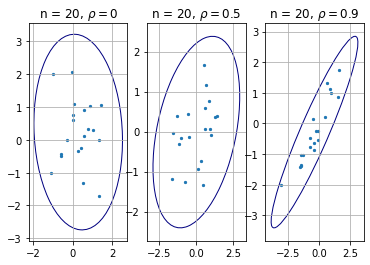


60
\begin{tabular}{llll}
\hline
 rho = 0 & r      & r\_\{S\} & r\_\{Q\} \\
 E(z)    & -0.002 & 0.002 & 0.0   \\
 E(z\^{}2)  & 0.009  & 0.009 & 0.004 \\
 D(z)    & 0.018  & 0.018 & 0.018 \\
\hline
\end{tabular}

60
\begin{tabular}{llll}
\hline
 rho = 0.5 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.503 & 0.481 & 0.333 \\
 E(z\^{}2)    & 0.253 & 0.231 & 0.111 \\
 D(z)      & 0.01  & 0.011 & 0.014 \\
\hline
\end{tabular}

60
\begin{tabular}{llll}
\hline
 rho = 0.9 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.902 & 0.887 & 0.733 \\
 E(z\^{}2)    & 0.813 & 0.787 & 0.538 \\
 D(z)      & 0.001 & 0.001 & 0.01  \\
\hline
\end{tabular}

60
\begin{tabular}{llll}
\hline
 size = 60 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.792 & 0.887 & 0.6   \\
 E(z\^{}2)    & 0.628 & 0.787 & 0.36  \\
 D(z)      & 0.003 & 0.001 & 0.011 \\
\hline
\end{tabular}


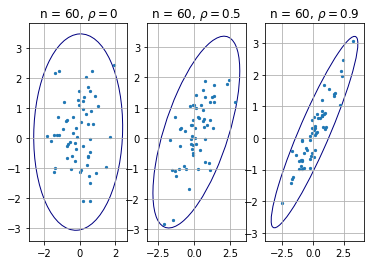


100
\begin{tabular}{llll}
\hline
 rho = 0 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)    & 0.003 & 0.003 & 0.0   \\
 E(z\^{}2)  & 0.005 & 0.005 & 0.006 \\
 D(z)    & 0.011 & 0.011 & 0.01  \\
\hline
\end{tabular}

100
\begin{tabular}{llll}
\hline
 rho = 0.5 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.499 & 0.477 & 0.32  \\
 E(z\^{}2)    & 0.249 & 0.228 & 0.102 \\
 D(z)      & 0.006 & 0.006 & 0.009 \\
\hline
\end{tabular}

100
\begin{tabular}{llll}
\hline
 rho = 0.9 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)      & 0.901 & 0.888 & 0.72  \\
 E(z\^{}2)    & 0.812 & 0.788 & 0.518 \\
 D(z)      & 0.0   & 0.001 & 0.005 \\
\hline
\end{tabular}

100
\begin{tabular}{llll}
\hline
 size = 100 & r     & r\_\{S\} & r\_\{Q\} \\
 E(z)       & 0.79  & 0.888 & 0.56  \\
 E(z\^{}2)     & 0.624 & 0.788 & 0.314 \\
 D(z)       & 0.002 & 0.001 & 0.007 \\
\hline
\end{tabular}


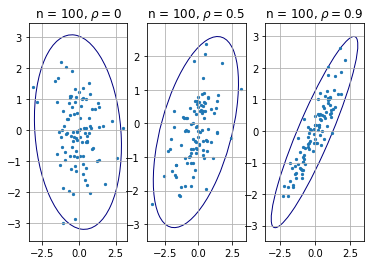

In [10]:
for size in sizes:
    for ro in ros:
        pearson, spirman, quadrant = count_coefficients(multivariate_normal, size, ro)
        print('\n' + str(size) + '\n' + str(create_table(pearson, spirman, quadrant, size, ro)))

    pearson, spearman, quadrant = count_coefficients(mix_multivariate_normal, size, 0)
    print('\n' + str(size) + '\n' + str(create_table(pearson, spirman, quadrant, size, -1)))
    show_ellipse(size)